### Optimal control of deterministic phenomenological network models with delays
This notebook shows how to compute the optimal control (OC) signal for phenomenological models (FHN, Hopf) for a simple example task in networks with delays.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn, oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

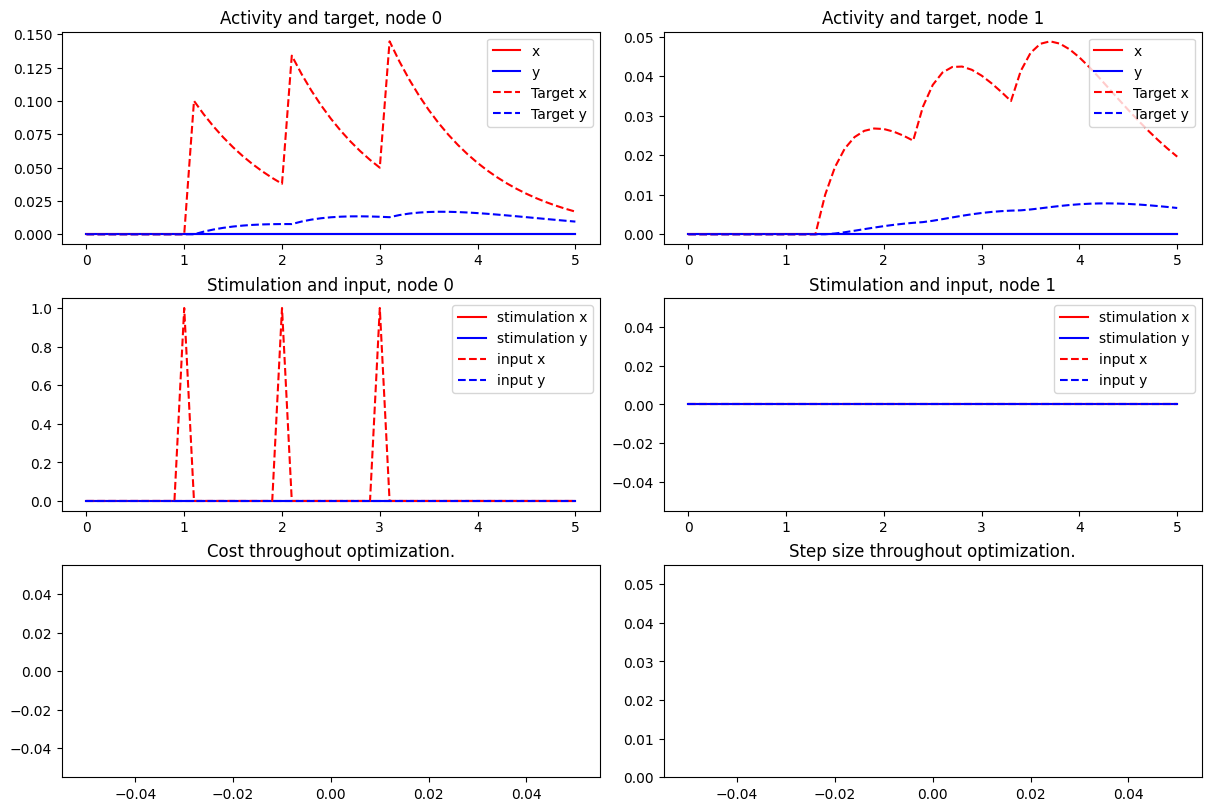

In [19]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [0.2, 0.]] ) # delay from 0 to 1

#model = FHNModel(Cmat=cmat, Dmat=dmat)
model = HopfModel(Cmat=cmat, Dmat=dmat)

duration, dt = 2000., 0.1
model.params.duration = duration
model.params.dt = dt

# change coupling parameters for faster and stronger connection between nodes
model.params.K_gl = 1.
model.params.signalV = 1.
if model.name == "hopf":
    model.params.a = -1. # only for Hopf model. Parameter "a" does not exist in FHN

model.params.x_ext = np.zeros((1,))
model.params.y_ext = np.zeros((1,))

model.run()

e0 = model.x[0,-1]
e1 = model.x[1,-1]
i0 = model.y[0,-1]
i1 = model.y[1,-1]

model.params["xs_init"] = np.array([[e0, e0, e0], [e1, e1, e1]])
model.params["ys_init"] = np.array([[i0, i0, i0], [i1, i1, i1]])

duration = 5.
model.params.duration = duration
time = np.arange(dt, duration+dt, dt)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,10] = 1. 
input[0,20] = 1.
input[0,30] = 1. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.params["xs_init"] = np.array([[e0, e0, e0], [e1, e1, e1]])
model.params["ys_init"] = np.array([[i0, i0, i0], [i1, i1, i1]])
model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

We now compute the optimal control. Compute 100 iterations first, then perform more iterations until convergence.

Compute control for a deterministic system
Cost in iteration 0: 0.002263077516533788
Cost in iteration 1: 0.0006352996350756684
Cost in iteration 2: 9.97995775147175e-05
Cost in iteration 10: 3.026909438644803e-05
Cost in iteration 50: 1.5293563703970727e-05
Cost in iteration 100: 9.08805440505221e-06
Final cost : 9.08805440505221e-06


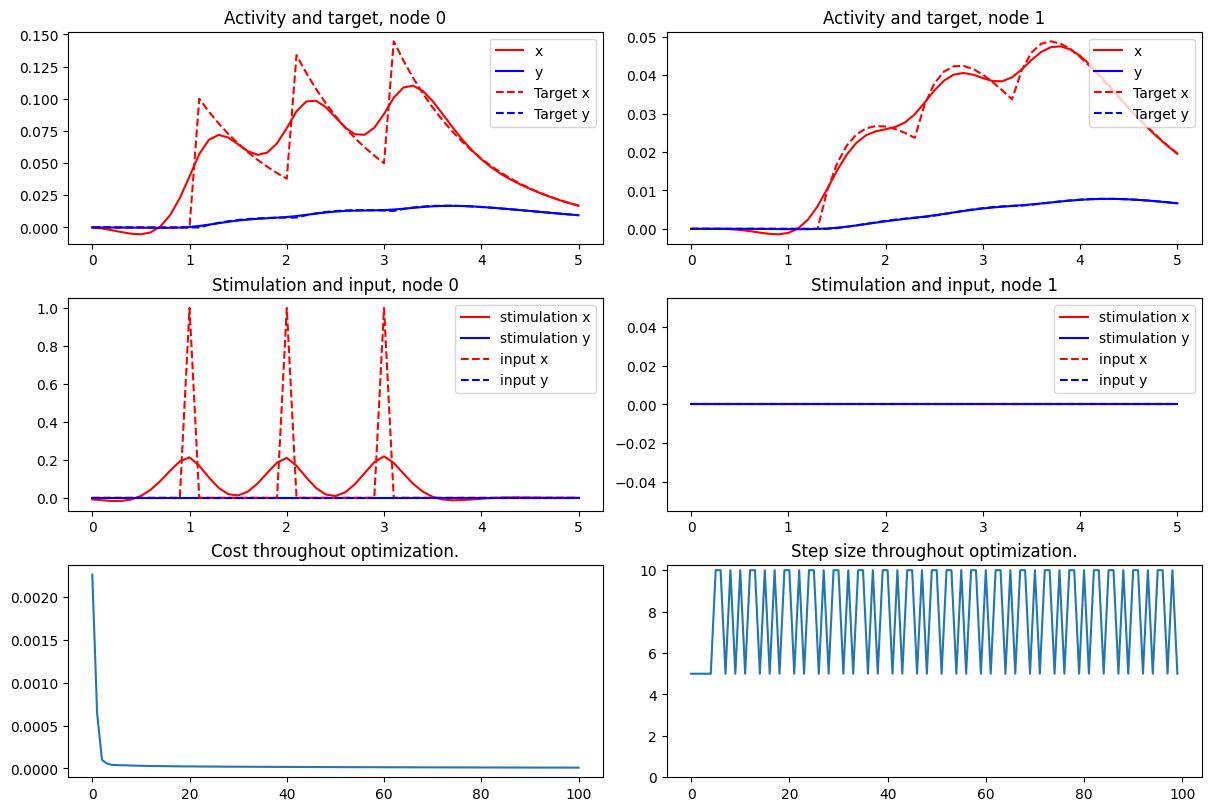

In [21]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

#model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500, 1000], control_matrix=control_mat, precision_matrix=prec_mat)
model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500, 1000], control_matrix=control_mat, precision_matrix=prec_mat)
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 1.4296341287319705e-06
Cost in iteration 1: 1.4280136656224365e-06
Cost in iteration 2: 1.4273440317248193e-06
Cost in iteration 10: 1.4203785402420486e-06
Cost in iteration 50: 1.3854707142764868e-06
Cost in iteration 100: 1.3442427318438192e-06
Cost in iteration 200: 1.2682983814795233e-06
Cost in iteration 300: 1.1982620277499969e-06
Cost in iteration 400: 1.135394770256451e-06
Cost in iteration 500: 1.0771167273492726e-06
Final cost : 1.0771167273492726e-06


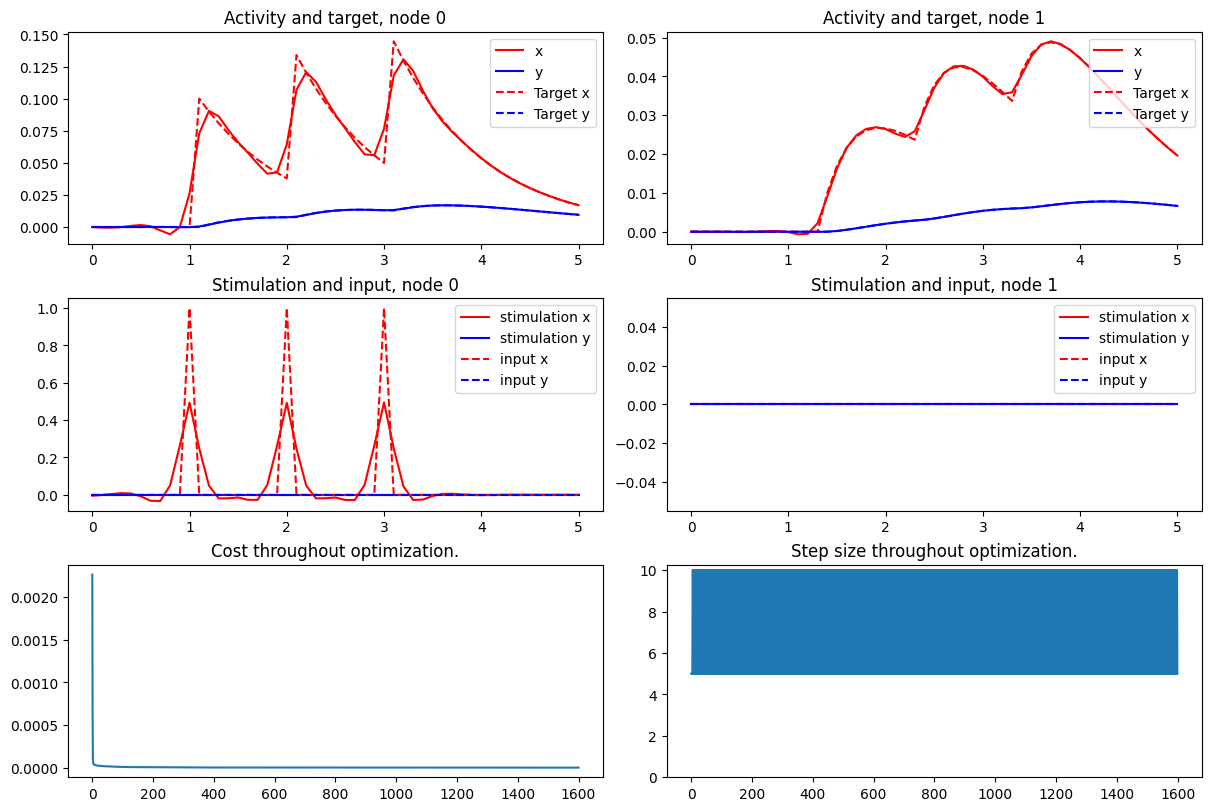

In [24]:
# perofrm another 500 iterations to improve result
# repeat execution to add another 500 iterations
model_controlled.optimize(500)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)